In [1]:
import os
import numpy as np
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as ss
from scipy.stats import kurtosis
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
from mne.viz import plot_epochs_image
from autoreject import AutoReject
from autoreject import Ransac
from autoreject import get_rejection_threshold
import pickle

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)

In [2]:
def get_bad_epochs(signal, percentile=25): #shape = ( epochs, channels, samples)
    channels = signal.shape[1]
    Qstd = np.std(signal,axis = -1)
    Qkurt = kurtosis(signal,axis = -1)
    bads = np.empty(0)
    for i in range(channels):
        Q1,Q3 = np.percentile(Qstd[:,i],[percentile,100-percentile])
        IQR = Q3-Q1
        range_std = (Q1-1.5*IQR,Q3+1.5*IQR)
        Q1,Q3 = np.percentile(Qkurt[:,i],[percentile,100-percentile])
        IQR = Q3-Q1
        range_kurt = (Q1-1.5*IQR,Q3+1.5*IQR)
        right_std = np.where(Qstd[:,i] > range_std[1])[0]
        left_std = np.where(Qstd[:,i] < range_std[0])[0]
        right_kurt = np.where(Qkurt[:,i] > range_kurt[1])[0]
        left_kurt = np.where(Qkurt[:,i] < range_kurt[0])[0]
        bads = np.unique(np.concatenate((bads,left_kurt,right_kurt,left_std,right_std)))
    return bads

def get_bad_channels(signal,percentile=30): #shape = (channels, samples)
    channels = signal.shape[1]
    Qstd = np.std(signal,axis = -1)
    Qkurt = kurtosis(signal,axis = -1)
    bads = np.empty(0)
    Q1,Q3 = np.percentile(Qstd,[percentile,100-percentile])
    IQR = Q3-Q1
    range_std = (Q1-1.5*IQR,Q3+1.5*IQR)
    Q1,Q3 = np.percentile(Qkurt,[percentile,100-percentile])
    IQR = Q3-Q1
    range_kurt = (Q1-1.5*IQR,Q3+1.5*IQR)
    right_std = np.where(Qstd > range_std[1])[0]
    left_std = np.where(Qstd < range_std[0])[0]
    right_kurt = np.where(Qkurt > range_kurt[1])[0]
    left_kurt = np.where(Qkurt < range_kurt[0])[0]
    bads = np.unique(np.concatenate((bads,left_kurt,right_kurt,left_std,right_std)))
    return bads
# mistakes = [True if i['word_type']!=i['decision'] else False for i in f.event['tag_type']]
# epo.drop(mistakes)
def getting_proper_decisions_ind(raw_file):
    pseudos = [i for i, trial in enumerate(raw_file.event['tag_type']) if trial['word_type']=='p' and trial['word_type']==trial['decision']]
    words = [i for i, trial in enumerate(raw_file.event['tag_type']) if trial['word_type']=='s' and trial['word_type']==trial['decision']]
    return pseudos, words

## Checkin if signals are cut accordingly to diode signal

In [3]:
data_path = './data/2_LDT/'

In [14]:
f = mne.io.read_raw_eeglab(data_path+'k2.set',preload=True)
ile = len(f.event['latency'])
EVENTS = np.zeros((ile,3))
EVENTS[:,0] = f.event['latency']
EVENTS[:,1] = 0
EVENTS[:,2] = 1
t = np.arange(-0.2,1.001,1/1024)
epo = mne.Epochs(f,EVENTS.astype(int),baseline = (-0.2,0),tmin= -0.2, tmax=1)
syg = epo.get_data()

Reading ./data/2_LDT/k2.fdt
Reading 0 ... 5092671  =      0.000 ...  4973.312 secs...
1635 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 1635 events and 1230 original time points ...
0 bad epochs dropped


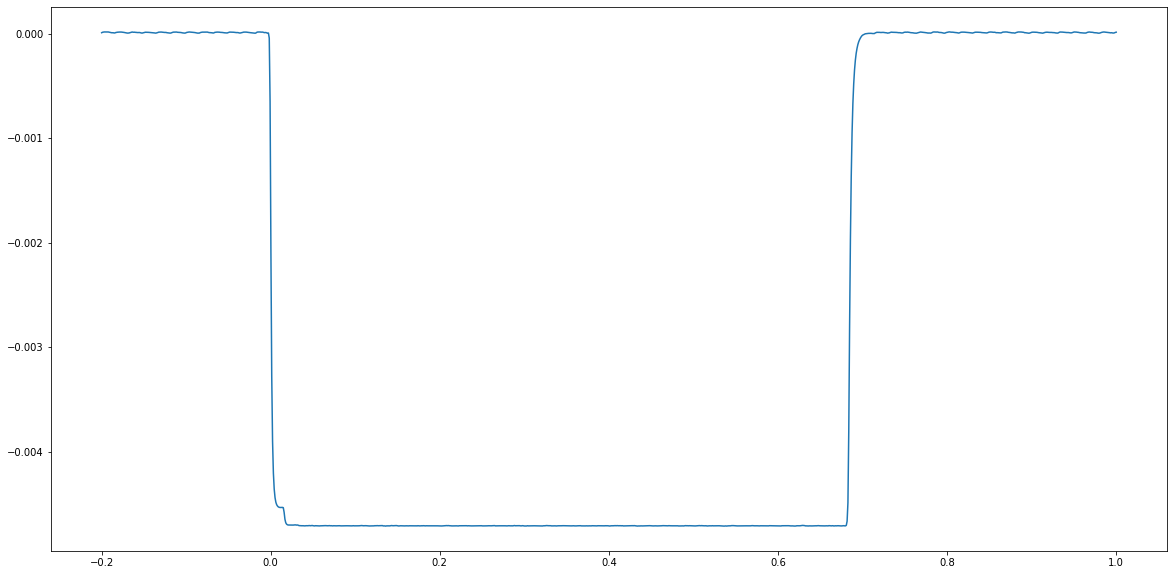

In [18]:
plt.plot(t,syg[1600,-2])
plt.show()

Loading data for 423 events and 1230 original time points ...
Loading data for 20 events and 1230 original time points ...


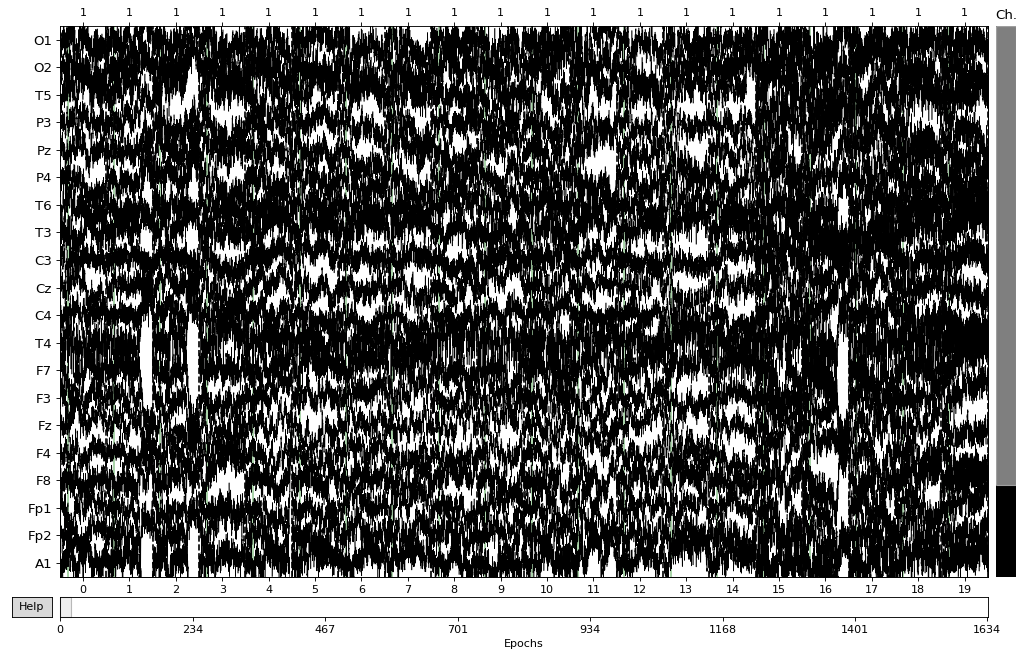

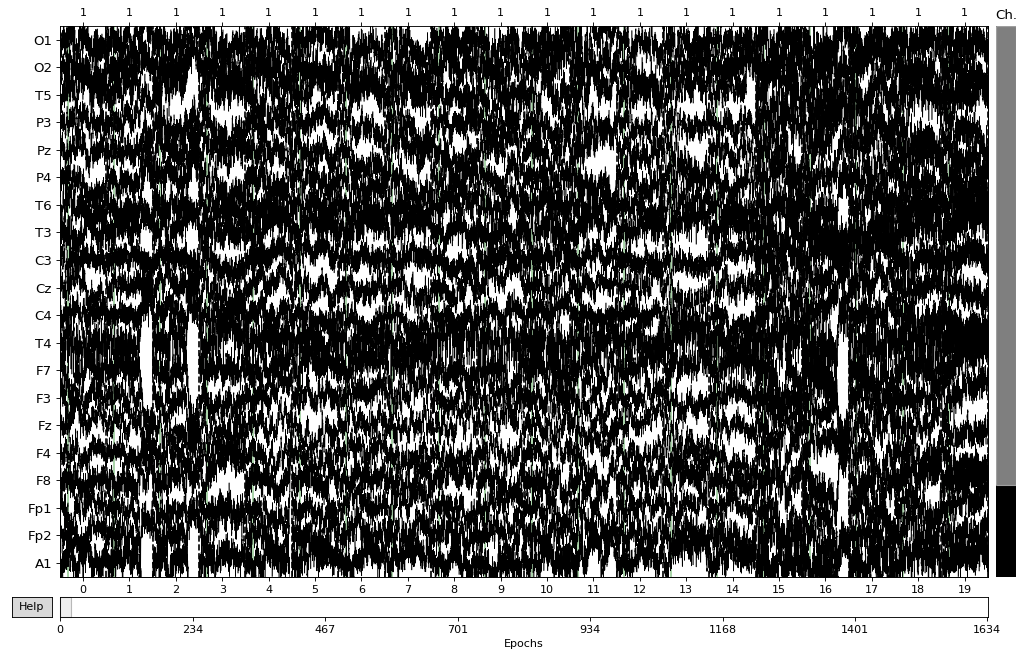

In [11]:
epo.plot()

 jeśli dla każdego trialu obliczycie np. std napięcia, obliczycie Q1 i Q3 (25 i 75 percentyl otrzymanych wartości) to outliery są to te wartości, które leżą poza zakresem [Q1-1.5*IQR, q3+1.5*IQR] , gdzie IQR = Q3-Q1; analogicznie dla kurtozy.

## Searching for bad channels

In [6]:
bads = np.empty(0)
for i in range(1,19):
    for gender in ('k','m'):
        filename = data_path + gender + f'{i}.set'
        f = mne.io.read_raw_eeglab(filename,preload=True)
        f.set_eeg_reference(ref_channels=['A1','A2'])
        f.drop_channels(['EOG','dioda','TSS','A1','A2'])
        f.filter(1,50)
        signals = f.get_data()
        bads = np.concatenate((bads,get_bad_channels(signals)))

Reading ./data/2_LDT/k1.fdt
Reading 0 ... 4466687  =      0.000 ...  4361.999 secs...
EEG channel type selected for re-referencing
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3379 samples (3.300 sec)

Reading ./data/2_LDT/m1.fdt
Reading 0 ... 4939295  =      0.000 ...  4823.530 secs...


KeyboardInterrupt: 

In [30]:
np.save('./temp/bad_channels.npy',np.unique(bads))

In [31]:
np.save('./temp/good_channels.npy', np.array([3,5,6,9,10,14,15]))

## Developing proper code for preprocessing raw signal

In [33]:
def reading_data(filename,bad_ch,tmin= -0.2, tmax=1):
    f = mne.io.read_raw_eeglab(filename,preload=True,verbose='warning')
    chann = f.ch_names
    ile = len(f.event['latency'])
    EVENTS = np.zeros((ile,3))
    EVENTS[:,0] = f.event['latency']
    EVENTS[:,1] = 0
    EVENTS[:,2] = 1
    f.set_eeg_reference(ref_channels=['A1','A2'])
    f.drop_channels(['EOG','dioda','TSS','A1','A2'])
    f.resample(256)
#     f.notch_filter(50)
    f.filter(1,40)#od 0.1 lepiej do 30
#     f.drop_channels(np.array(chann)[bad_ch.astype(int)])
#     signals = f.get_data()
#     bads = get_bad_channels(signals)
#     f.info['bads'] = np.array(chann)[bads.astype(int)]
#     f.plot()
#     print(f.info['bads'])
#     f = f.interpolate_bads(reset_bads=True, verbose=True, origin=np.array([0,0,0]))
#     f.plot()
    syg_raw = f.get_data()
    epo = mne.Epochs(f,EVENTS.astype(int),baseline = (-0.2,0),tmin=tmin, tmax=tmax,metadata = pd.DataFrame(f.event['tag_type']),verbose='warning', preload=True)
    mistakes = [True if epo._metadata['word_type'][i]!=epo._metadata['decision'][i] else False for i in range(0, len(epo))]
    epo.drop(mistakes)

    word_type = np.array([0 if i == 'p' else 1 for i in epo._metadata['word_type']])
    # xDAWN
#     plot_epochs_image(epo)
#     epo.plot()

    picks = mne.pick_types(epo.info, meg=False, eeg=True,
                       stim=False, eog=False,
                       include=[], exclude=[])
    ransac = Ransac(verbose='progressbar', picks=picks, n_jobs=3)
    epo = ransac.fit_transform(epo)
    
#     ar = AutoReject(n_jobs=3)
#     epo = ar.fit_transform(epo)

    reject = get_rejection_threshold(epo, decim=2)
    epo.drop_bad(reject=reject)
    
    syg = epo.get_data()
#     epo.drop(get_bad_epochs(syg))
    
#     epo.plot()
    temp_syg = epo.get_data()
    temp_syg = temp_syg.reshape([temp_syg.shape[1],temp_syg.shape[0]*temp_syg.shape[2]])
    signal_cov = mne.compute_raw_covariance(mne.io.RawArray(temp_syg, epo[0].info))
    xd = mne.preprocessing.Xdawn(n_components=2, signal_cov=signal_cov)
    xd.fit(epo)
    epochs_denoised = xd.apply(epo)
    epo_xDAWN = next(iter(epochs_denoised.values()))

    epo.plot()
#     plot_epochs_image(epo)
    return word_type, epo, epo_xDAWN

Iterating epochs ...


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s finished
/home/mateusz_personal/.local/lib/python3.8/site-packages/autoreject/ransac.py:226: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs.interpolate_bads(reset_bads=True)


[Done]
Estimating rejection dictionary for eeg


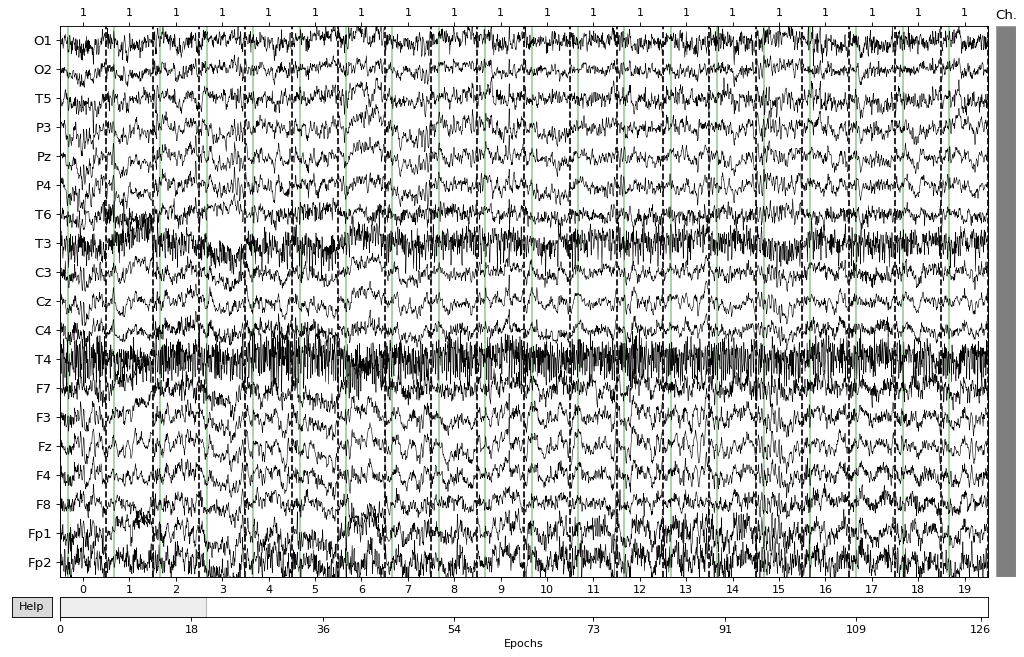

Iterating epochs ...


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.0s finished
/home/mateusz_personal/.local/lib/python3.8/site-packages/autoreject/ransac.py:226: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs.interpolate_bads(reset_bads=True)


[Done]
Estimating rejection dictionary for eeg


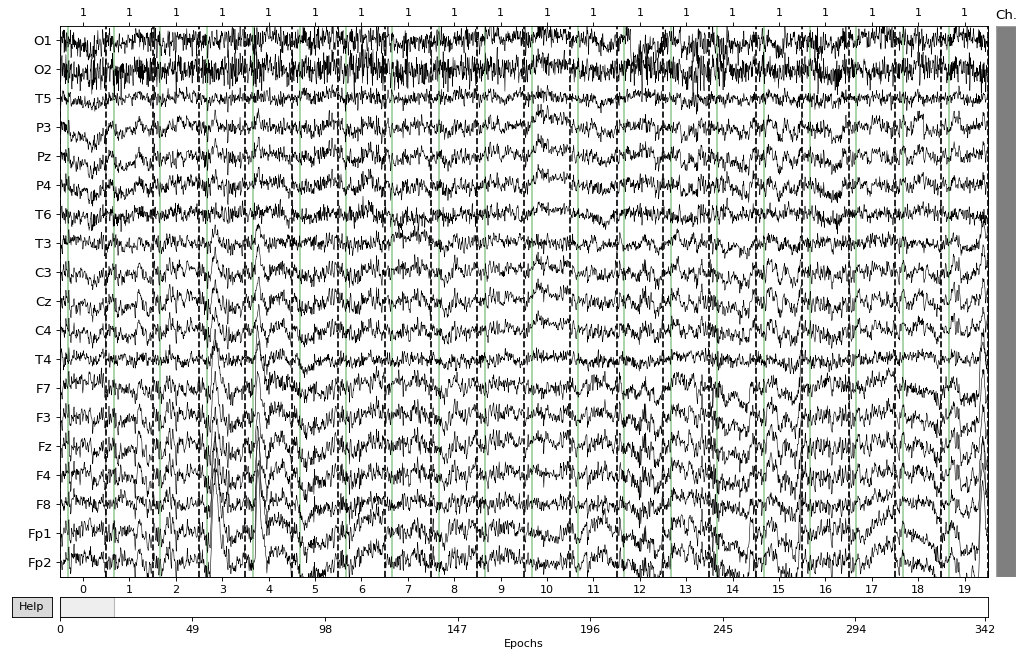

Iterating epochs ...


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.0s finished
/home/mateusz_personal/.local/lib/python3.8/site-packages/autoreject/ransac.py:226: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs.interpolate_bads(reset_bads=True)


[Done]
Estimating rejection dictionary for eeg


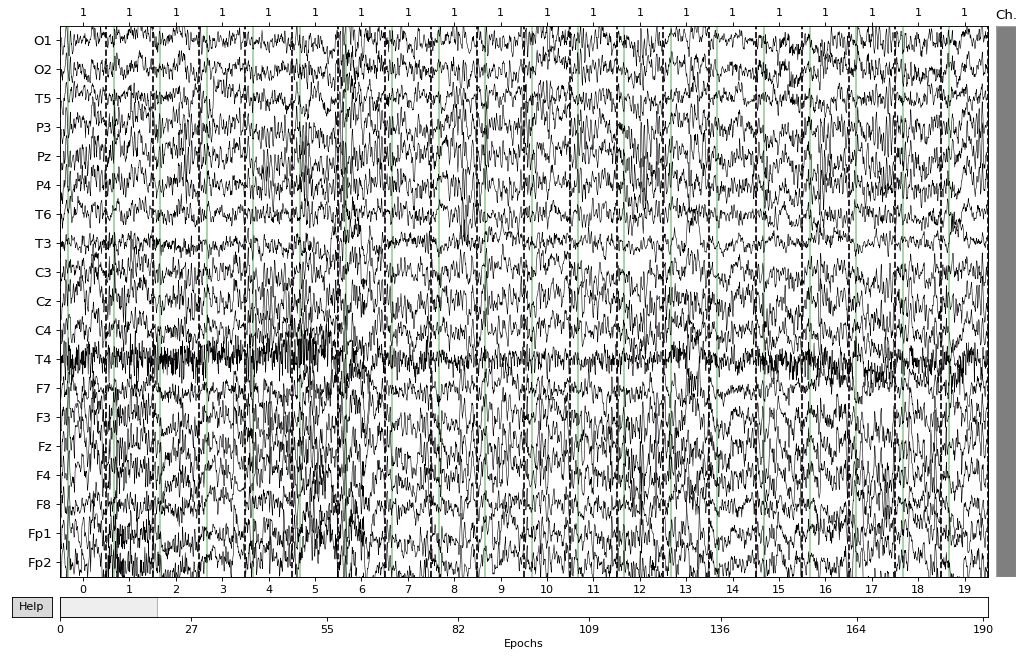

Iterating epochs ...


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.1s finished
/home/mateusz_personal/.local/lib/python3.8/site-packages/autoreject/ransac.py:226: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs.interpolate_bads(reset_bads=True)


[Done]
Estimating rejection dictionary for eeg


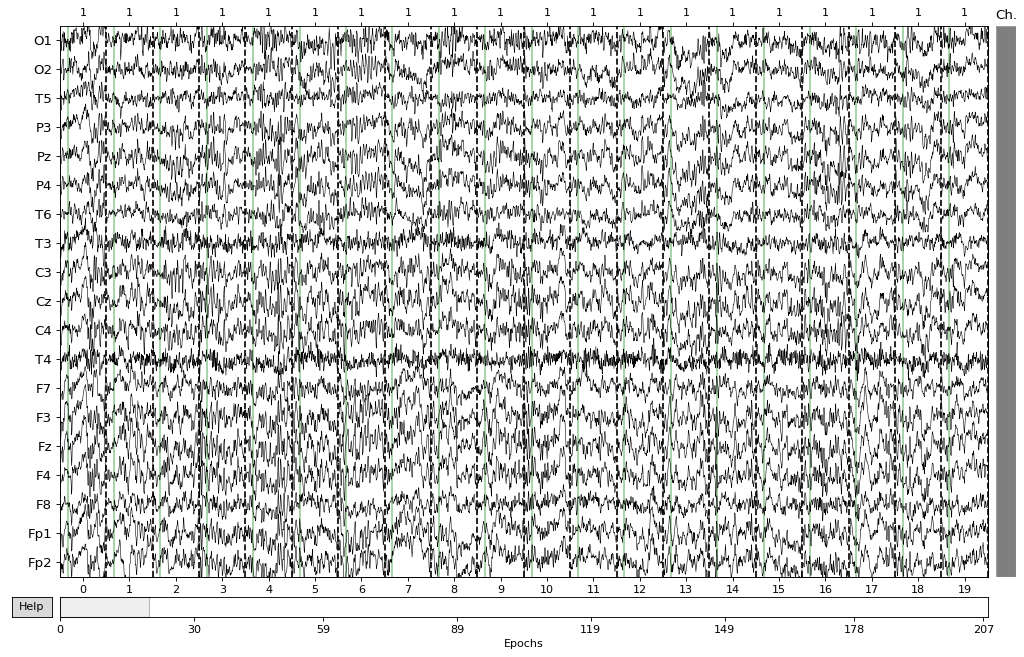

In [34]:
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['figure.figsize'] = [20, 10]
y = np.empty(0)
# X = np.zeros((0,7,1230))
X = np.zeros((0,19,1230))
X_xDAWN = np.zeros((0,19,1230))
bad = np.load('./temp/bad_channels.npy')
suffix = '125'
for i in range(1,3):
    for gender in ('k','m'):
        filename = data_path + gender + f'{i}.set'
        typ, epo, epo_xDAWN = reading_data(filename,bad,tmin= -0.2, tmax=1)
        y = np.concatenate((y,typ))
#         X.append(epo)
        sig = epo.get_data()
        np.save(f'./temp/{gender}{i}{suffix}.npy', sig)
        PIK = f'./temp/{gender}{i}{suffix}.dat'
        with open(PIK, 'wb') as f:
            pickle.dump(epo, f)
#         X = np.concatenate((X,sig))
        sig = epo_xDAWN.get_data()
        np.save(f'./temp/{gender}{i}_xDAWN{suffix}.npy', sig)
        PIK = f'./temp/{gender}{i}_xDAWN{suffix}.dat'
        with open(PIK, 'wb') as f:
            pickle.dump(epo_xDAWN, f)
#         X_xDAWN = np.concatenate((X_xDAWN,sig))

In [16]:
epo.plot()

NameError: name 'epo' is not defined

In [19]:
X.shape

(2113, 7, 1230)

In [15]:
X.shape

(1922, 7, 1230)

In [12]:
epo.info

<Info | 9 non-empty values
 bads: []
 ch_names: O1, O2, T5, P3, Pz, P4, T6, T3, C3, Cz, C4, T4, F7, F3, Fz, F4, ...
 chs: 19 EEG
 custom_ref_applied: True
 dig: 24 items (24 EEG)
 highpass: 1.0 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 nchan: 19
 projs: []
 sfreq: 1024.0 Hz
>

In [6]:
import pickle
PIK = "./processed_data/2_LDT_epochs.dat"

with open(PIK, "wb") as f:
    pickle.dump(X, f)

In [ ]:
np.save('./processed_data/2_LDT_y_autoreject.npy',y)

In [ ]:
np.save('./processed_data/2_LDT_X_4_autoreject.npy',X)

In [8]:
np.save('./processed_data/2_LDT_y_autoreject_xDAWN.npy',y)

In [ ]:
np.save('./processed_data/2_LDT_X_4_autoreject_xDAWN.npy',X_xDAWN)

In [8]:
X.shape

(41461, 7, 1230)

In [12]:
epo._metadata

NameError: name 'epo' is not defined

In [10]:
!python3 --version

Python 3.8.2


In [34]:
X.shape

(42744, 7, 1230)

In [35]:
y.shape

(42744,)

In [36]:
np.save('X_new.npy',X)
np.save('y_new.npy',y)

In [45]:
niezero = np.nonzero(y)[0]
zero = np.where(y == 0)[0]

In [48]:
pseudo_X = X[zero,:,:]
word_X = X[niezero,:,:]

In [49]:
mean_pseudo = np.mean(pseudo_X,axis=0)
mean_word = np.mean(word_X,axis=0)


(7, 1230)

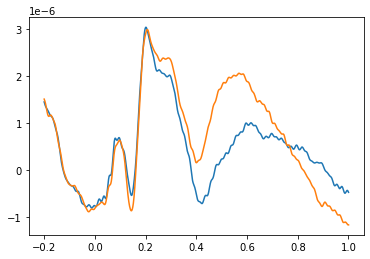

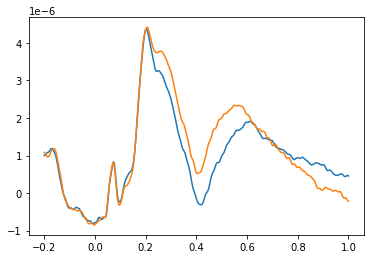

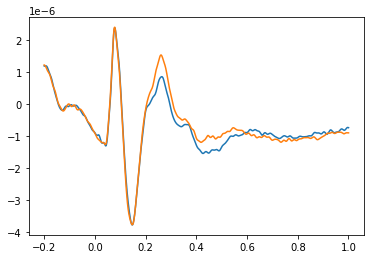

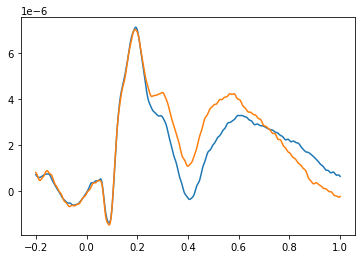

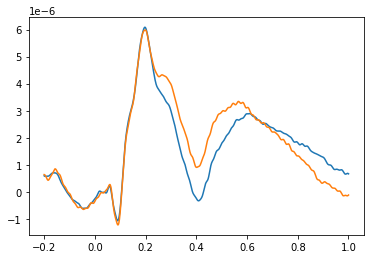

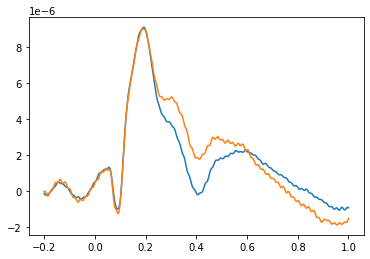

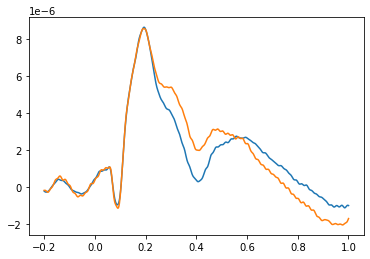

In [51]:
for i in range(7):
    plt.plot(t,mean_pseudo[i,:])
    plt.plot(t,mean_word[i,:])
    plt.show()

In [52]:
epo.ch_names

['P3', 'P4', 'T6', 'Cz', 'C4', 'Fz', 'F4']

In [2]:
X = np.zeros((0,19,1230))
y = np.empty(0)
for i in range(1,19):
    for gender in ('k','m'):
        filename = './temp/' + gender + f'{i}.dat'
        print(filename)
        file = open(filename,'rb')
        epo = pickle.load(file)
        sig = epo.get_data()
        typ = np.array([0 if i == 'p' else 1 for i in epo._metadata['word_type']])
        X = np.concatenate((X,sig))
        y = np.concatenate((y,typ))

./temp/k1.dat


NameError: name 'X' is not defined

In [5]:
X_train = np.zeros((0,19,1230))
X_valid = np.zeros((0,19,1230))
y_train = np.empty(0)
y_valid = np.empty(0)
for i in range(1,19):
    for gender in ('k','m'):
        filename = './temp/' + gender + f'{i}_xDAWN.dat'
        print(filename)
        file = open(filename,'rb')
        epo = pickle.load(file)
        sig = epo.get_data()
        typ = np.array([0 if i == 'p' else 1 for i in epo._metadata['word_type']])
        cut_point = sig.shape[0]//3
        X_train = np.concatenate((X_train,sig[cut_point:]))
        y_train = np.concatenate((y_train,typ[cut_point:]))
        
        X_valid = np.concatenate((X_valid,sig[:cut_point]))
        y_valid = np.concatenate((y_valid,typ[:cut_point]))

./temp/k1_xDAWN.dat
./temp/m1_xDAWN.dat
./temp/k2_xDAWN.dat
./temp/m2_xDAWN.dat
./temp/k3_xDAWN.dat
./temp/m3_xDAWN.dat
./temp/k4_xDAWN.dat
./temp/m4_xDAWN.dat
./temp/k5_xDAWN.dat
./temp/m5_xDAWN.dat
./temp/k6_xDAWN.dat
./temp/m6_xDAWN.dat
./temp/k7_xDAWN.dat
./temp/m7_xDAWN.dat
./temp/k8_xDAWN.dat
./temp/m8_xDAWN.dat
./temp/k9_xDAWN.dat
./temp/m9_xDAWN.dat
./temp/k10_xDAWN.dat
./temp/m10_xDAWN.dat
./temp/k11_xDAWN.dat
./temp/m11_xDAWN.dat
./temp/k12_xDAWN.dat
./temp/m12_xDAWN.dat
./temp/k13_xDAWN.dat
./temp/m13_xDAWN.dat
./temp/k14_xDAWN.dat
./temp/m14_xDAWN.dat
./temp/k15_xDAWN.dat
./temp/m15_xDAWN.dat
./temp/k16_xDAWN.dat
./temp/m16_xDAWN.dat
./temp/k17_xDAWN.dat
./temp/m17_xDAWN.dat
./temp/k18_xDAWN.dat
./temp/m18_xDAWN.dat


In [3]:
X.shape

(26686, 19, 1230)

In [4]:
y.shape

(26686,)

In [6]:
np.save('./processed_data/2_LDT_X_train_final.npy',X_train)
np.save('./processed_data/2_LDT_y_train_final.npy',y_train)

np.save('./processed_data/2_LDT_X_valid_final.npy',X_valid)
np.save('./processed_data/2_LDT_y_valid_final.npy',y_valid)

In [5]:
np.save('./processed_data/2_LDT_X_final.npy',X)

In [6]:
np.save('./processed_data/2_LDT_y_final.npy',y)

In [20]:
y.shape

(56463,)

In [6]:
tmin= -0.2
tmax=1
f = mne.io.read_raw_eeglab('./data/2_LDT/k1.set',preload=True,verbose='warning')
chann = f.ch_names
ile = len(f.event['latency'])
EVENTS = np.zeros((ile,3))
EVENTS[:,0] = f.event['latency']
EVENTS[:,1] = 0
EVENTS[:,2] = 1
f.set_eeg_reference(ref_channels=['A1','A2'])
f.drop_channels(['EOG','dioda','TSS','A1','A2'])
f.filter(1,50)
#     f.drop_channels(np.array(chann)[bad_ch.astype(int)])
#     signals = f.get_data()
#     bads = get_bad_channels(signals)
#     f.info['bads'] = np.array(chann)[bads.astype(int)]
#     f.plot()
#     print(f.info['bads'])
#     f = f.interpolate_bads(reset_bads=True, verbose=True, origin=np.array([0,0,0]))
#     f.plot()
syg_raw = f.get_data()
epo = mne.Epochs(f,EVENTS.astype(int),baseline = (-0.2,0),tmin=tmin, tmax=tmax,metadata = pd.DataFrame(f.event['tag_type']),verbose='warning', preload=True)

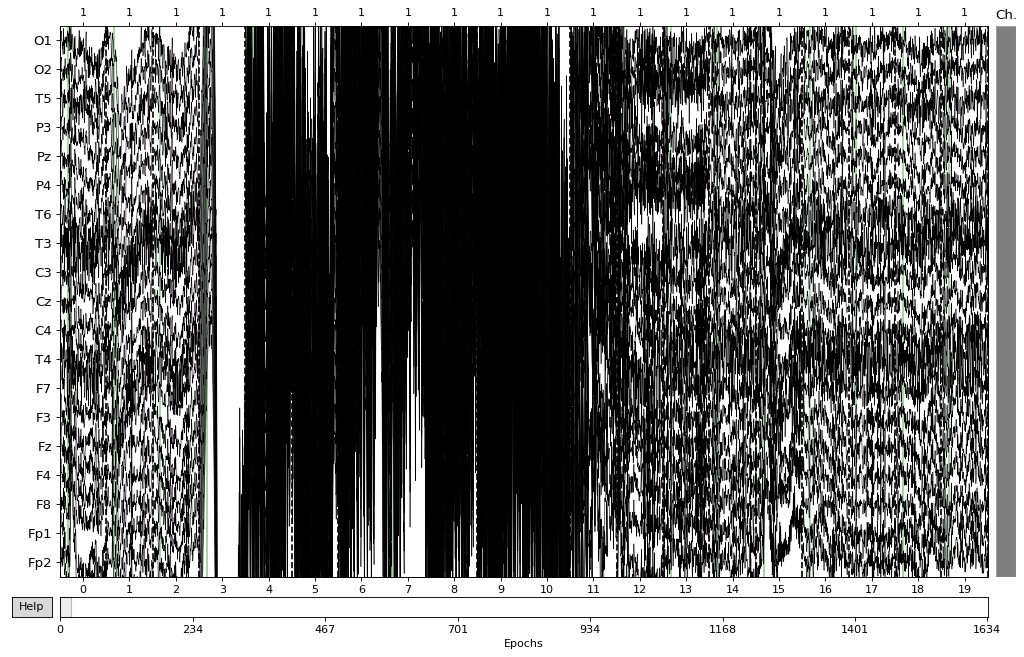

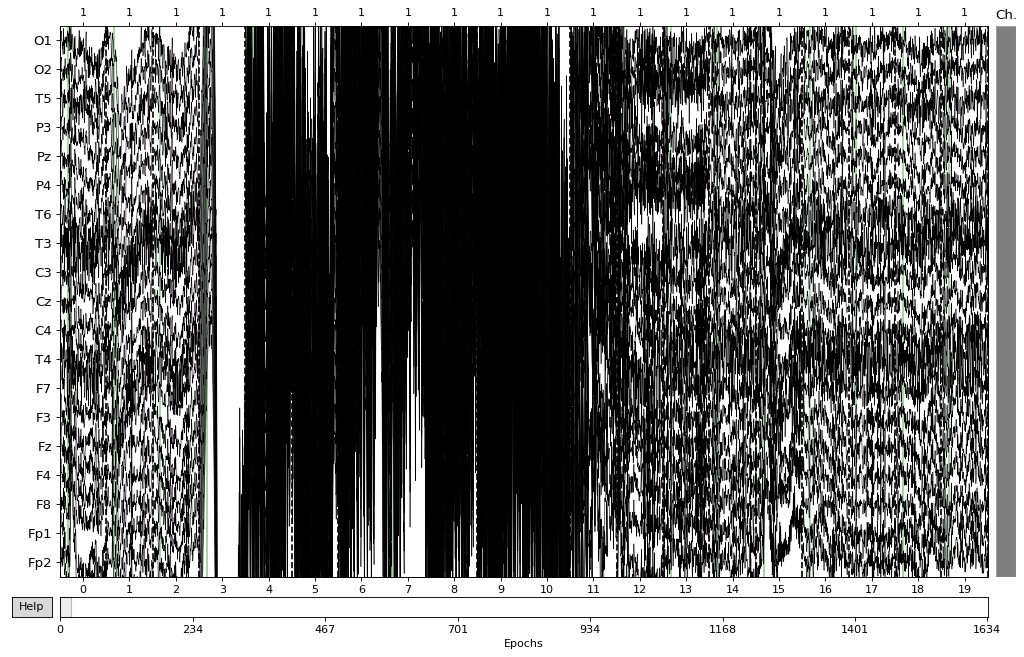

In [7]:
epo.plot()

In [ ]:
file = open("./temp/k1.dat",'rb')
object_file = pickle.load(file)
object_file.plot()

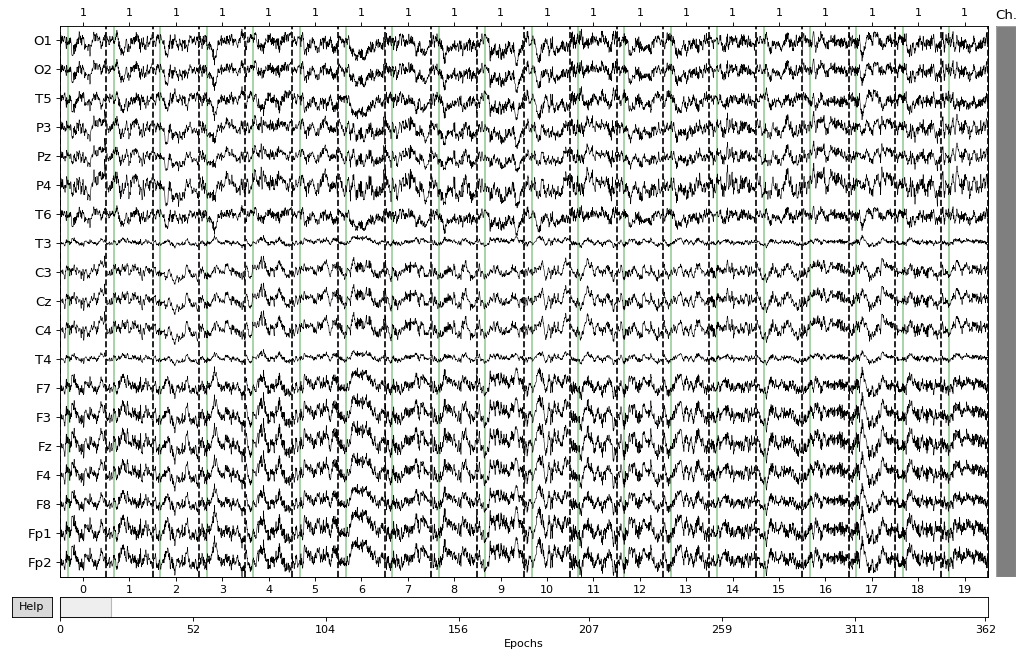

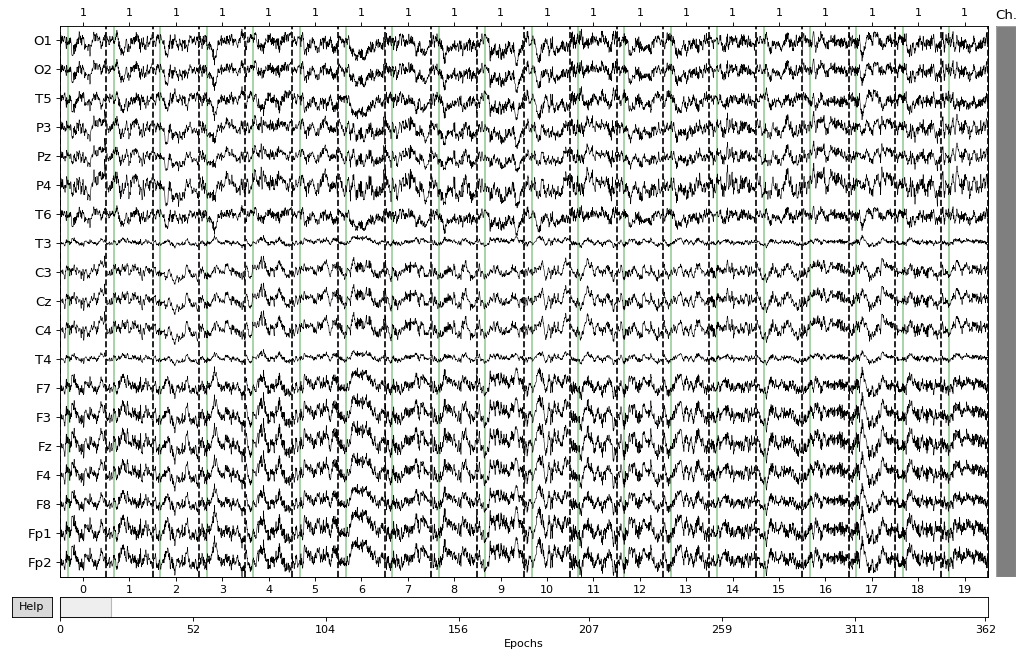

In [8]:
file = open("./temp/k1_xDAWN.dat",'rb')
object_file = pickle.load(file)
object_file.plot()

438     p
442     s
448     p
451     p
454     p
       ..
1548    p
1558    s
1559    s
1566    p
1572    p
Name: word_type, Length: 363, dtype: object